In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
def get_lower(x: str) -> str:
    return x.replace(' ', '_').lower()

def one_hot_encoding(df, cat_features=None, drop_original=True):
    df_copy = df.copy()
    if cat_features is None:
        cat_features = df.columns
    for feature in cat_features:
        df_copy = pd.concat([df_copy, 
                             pd.get_dummies(df[feature], 
                                            prefix=feature, 
                                            dummy_na=True)
                            ],
                            axis=1)
    if drop_original:
        df_copy.drop(cat_features, axis=1, inplace=True)
    return df_copy

def agg_features(df, df_out, by: str):
    df_copy = df.copy()
    df_out_copy = df_out.copy()
    cols = df_copy.drop(by, axis=1).columns
    for feature in cols:
        feature_groupby = df_copy.groupby(by, as_index=False)
        feature_counts = feature_groupby[feature].mean()
        feature_counts = feature_counts.rename(columns={
            feature: feature + f'_mean'
        })
        df_out_copy = df_out_copy.merge(feature_counts, how="left", on=by)
    return df_out_copy

def get_input(data_path: str,
              base_path: str= './data/',
              col_lower=True) -> pd.DataFrame:
    data = pd.read_csv(f'{base_path}/{data_path}')
    if col_lower:
        data.columns = [col.lower() for col in data.columns]
    print(f'{data_path}: {data.shape[0]} rows, {data.shape[1]} cols')
    return data


def clip_outliers(X, lower=0.005, upper=0.995):
    new_X = X.copy()
    new_X = new_X.apply(lambda x: x.clip(*x.quantile([lower, upper])), axis=1)

    return new_X

def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

def get_isna_features(X):
    X_copy = X.copy()
    for feature in X.columns:
        new_f = np.zeros(X.shape[0])
        new_f = X[feature].isna()
        X_copy[f'isna_{feature}'] = new_f.astype(int)
    return X_copy

In [3]:
train = get_input('train.csv')
test = get_input('test.csv')

train.csv: 110093 rows, 3 cols
test.csv: 165141 rows, 2 cols


In [4]:
target_name = 'target'
target = train[target_name]

In [5]:
payments = get_input('payments.csv')
payments.head(3)

payments.csv: 1023932 rows, 8 cols


,prev_application_number,application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945


In [6]:
train = train.merge(payments, how="left", on='application_number')
test = test.merge(payments, how="left", on='application_number')

In [7]:
numerical_features = payments.select_dtypes(exclude=["object"]).columns.tolist()
categorical_features = payments.select_dtypes(include=["object"]).columns.tolist()

In [10]:
koef = round(target.value_counts()[0] / target.value_counts()[1])
koef

11

In [9]:
train[categorical_features].head(3)

""
0
1
2


In [8]:
### categorical

Их нет

In [12]:
### descrete

In [13]:
discrete_feature = [
    feature for feature in numerical_features
    if len(payments[feature].unique())<25
]

In [14]:
payments[discrete_feature].head()

""
0
1
2
3
4


Таких тоже нет

In [15]:
### continuous

In [16]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 8


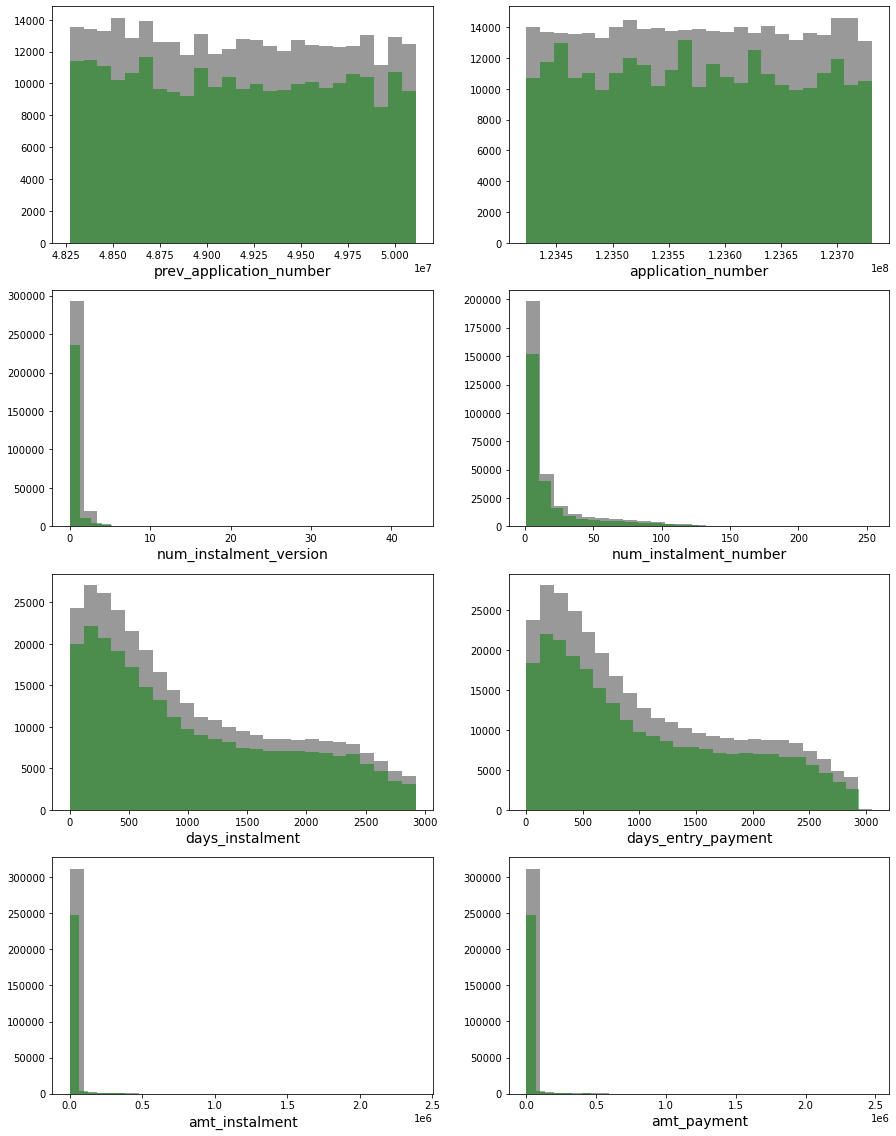

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    data_target = train.loc[train[target_name] == 1, feature]
    # масштабирую распределение срабатывание таргета, чтобы было видно форму
    data_target = pd.concat([data_target for _ in range(10)], axis=0)
    axes[num//2, num%2].hist(data, bins=25, color="grey", alpha=0.8)
    axes[num//2, num%2].hist(data_target, bins=25, color="green", alpha=0.5)
    axes[num//2, num%2].set_xlabel(feature, fontsize=14)

Все распределения очень похожи

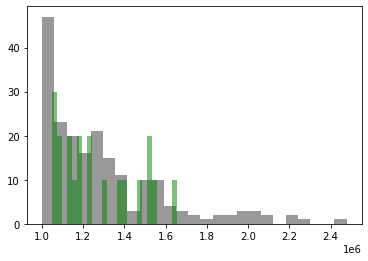

In [28]:
feature = 'amt_payment'
data = train.copy().loc[train[feature] > 1e6][[feature, target_name]]
data_target = data.loc[data[target_name] == 1, feature]
# масштабирую распределение срабатывание таргета, чтобы было видно форму
data_target = pd.concat([data_target for _ in range(10)], axis=0)
plt.hist(data[feature], bins=25, color="grey", alpha=0.8)
plt.hist(data_target, bins=25, color="green", alpha=0.5)
plt.show()

In [20]:
check_missings(train)

Total NA-values = 196996


,application_number,target,name_contract_type,prev_application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
Total,0,0,0,28126,28126,28126,28126,28183,28126,28183
Percent,0,0,0,8.15093,8.15093,8.15093,8.15093,8.16745,8.15093,8.16745
Types,int64,int64,object,float64,float64,float64,float64,float64,float64,float64


In [21]:
check_missings(test)

Total NA-values = 298168


,application_number,name_contract_type,prev_application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
Total,0,0,42568,42568,42568,42568,42664,42568,42664
Percent,0,0,8.24964,8.24964,8.24964,8.24964,8.26825,8.24964,8.26825
Types,int64,object,float64,float64,float64,float64,float64,float64,float64


In [22]:
train_na_features = get_isna_features(train)
train_na_features.head()

,application_number,target,name_contract_type,prev_application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment,isna_application_number,isna_target,isna_name_contract_type,isna_prev_application_number,isna_num_instalment_version,isna_num_instalment_number,isna_days_instalment,isna_days_entry_payment,isna_amt_instalment,isna_amt_payment
0,123687442,0,Cash,49796018.0,1.0,4.0,2830.0,2830.0,3289.635,3289.635,0,0,0,0,0,0,0,0,0,0
1,123687442,0,Cash,49796018.0,1.0,7.0,2740.0,2740.0,3289.635,3289.635,0,0,0,0,0,0,0,0,0,0
2,123687442,0,Cash,49713743.0,1.0,5.0,2551.0,2547.0,9262.215,9251.865,0,0,0,0,0,0,0,0,0,0
3,123687442,0,Cash,49713743.0,1.0,7.0,2491.0,2519.0,9262.215,10.350,0,0,0,0,0,0,0,0,0,0
4,123597908,1,Cash,49672074.0,1.0,9.0,450.0,457.0,11349.900,11349.900,0,0,0,0,0,0,0,0,0,0


In [23]:
isna_features = [feature for feature in train_na_features if feature.startswith('isna_')]

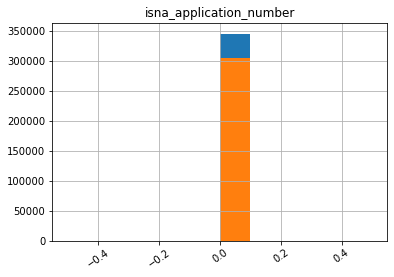

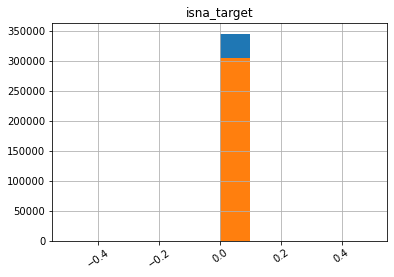

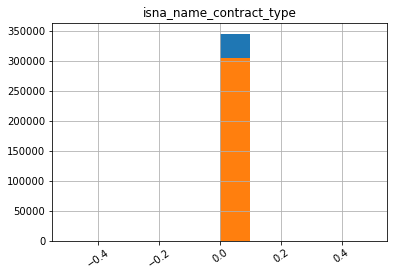

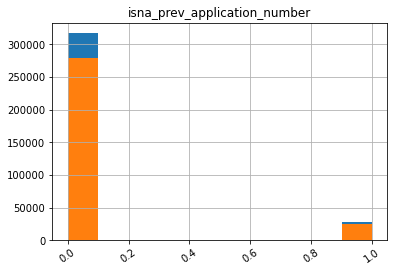

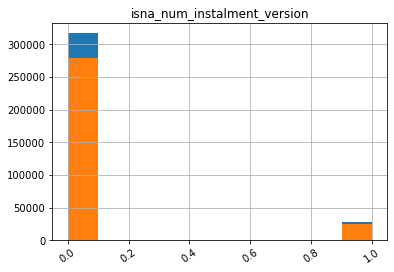

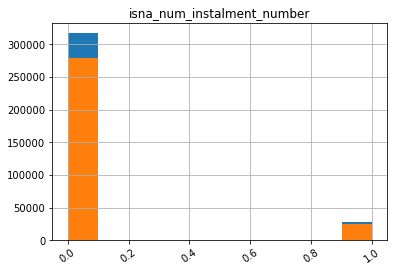

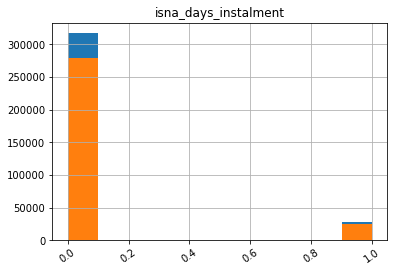

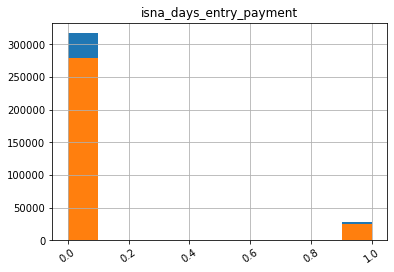

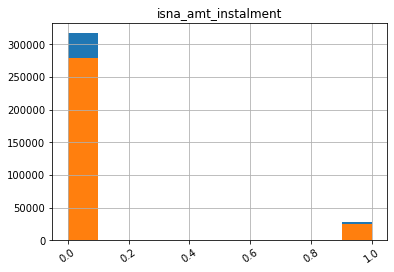

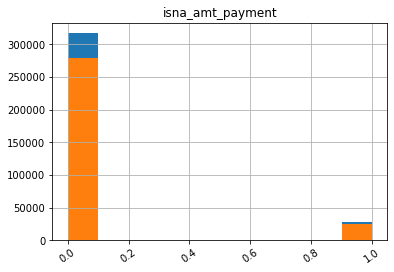

In [24]:
for feature in isna_features:
    plt.title(feature)
    train_na_features[feature].hist()
    data_target = train_na_features.loc[train_na_features[target_name] == 1, feature]
    data_target = pd.concat([data_target for _ in range(koef)], axis=0)
    data_target.hist()
    plt.xticks(rotation=35)
    plt.show()

На вид различия есть

In [25]:
isna_influence = dict()
for feature in isna_features:
    if feature in ['isna_application_number','isna_target','isna_name_contract_type']:
        continue
    data_target = train_na_features.loc[train_na_features[target_name] == 1]
    a = train_na_features.loc[train_na_features[feature] == 0, feature].count()
    a = a / train_na_features.loc[train_na_features[feature] == 1, feature].count()
    b = data_target.loc[data_target[feature] == 0, feature].count()
    b = b / data_target.loc[data_target[feature] == 1, feature].count()
    isna_influence[feature] = abs(a - b)
    
isna_influence = pd.DataFrame(isna_influence.items(), 
                              columns=['feature', 'influence'])\
                .sort_values(by='influence', ascending=False)
isna_influence

,feature,influence
0,isna_prev_application_number,0.026438
1,isna_num_instalment_version,0.026438
2,isna_num_instalment_number,0.026438
3,isna_days_instalment,0.026438
5,isna_amt_instalment,0.026438
4,isna_days_entry_payment,0.013136
6,isna_amt_payment,0.013136


а цифры говорят об обратном

In [26]:
isna_influence.loc[isna_influence['influence'] > 0.2, 'feature'].tolist()

[]